In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from data.eshape.help_functions import *


# Read data

In [2]:
data = pd.read_csv("eshape/data.csv")
ref_values = pd.read_csv("eshape/reference.csv")
validation = pd.read_csv("eshape/labels.csv")

# Plot reference parcels 
NDVI curves of the reference parcels along with the corresponding phenological stages

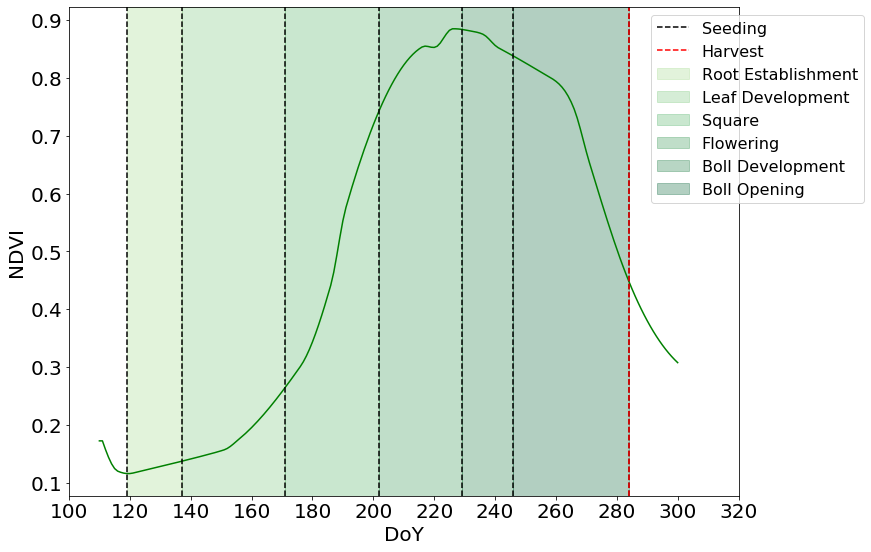

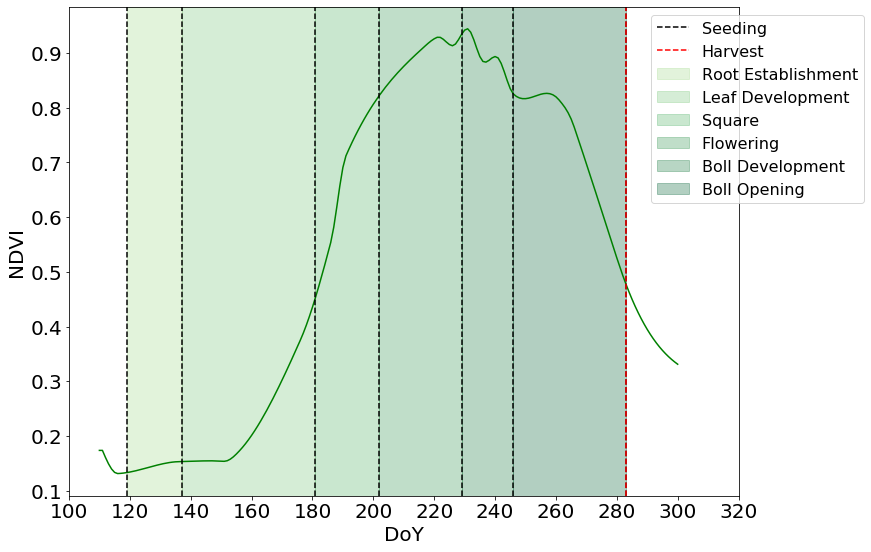

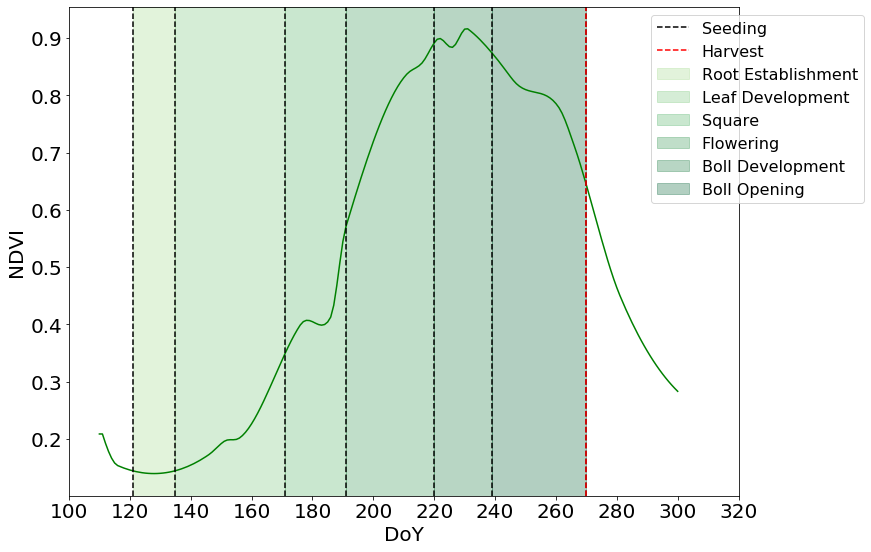

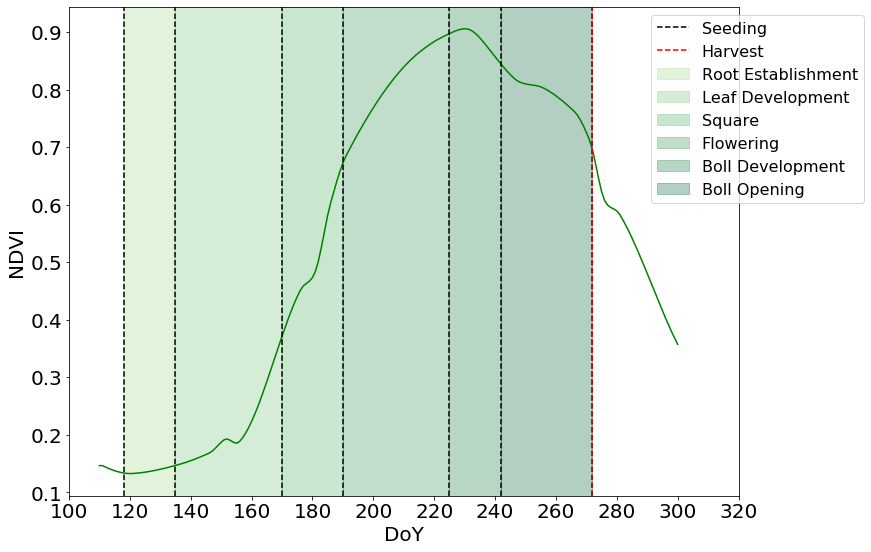

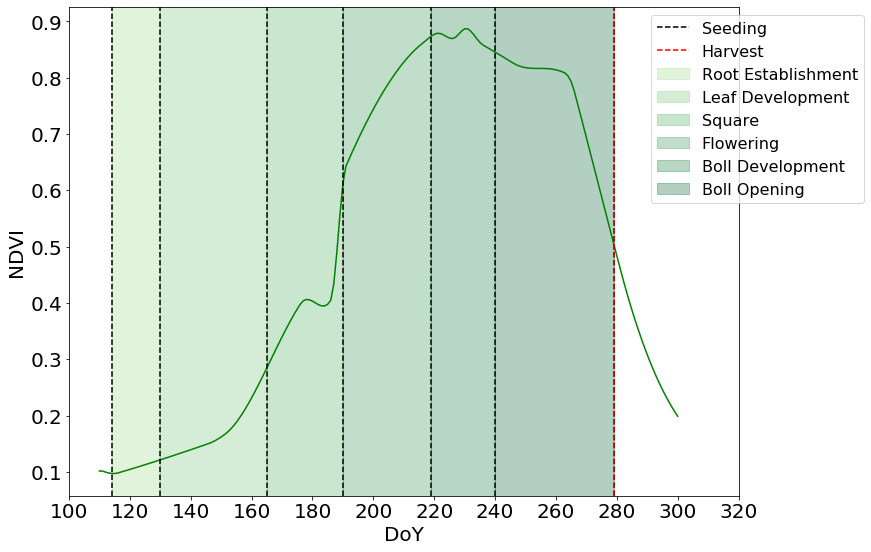

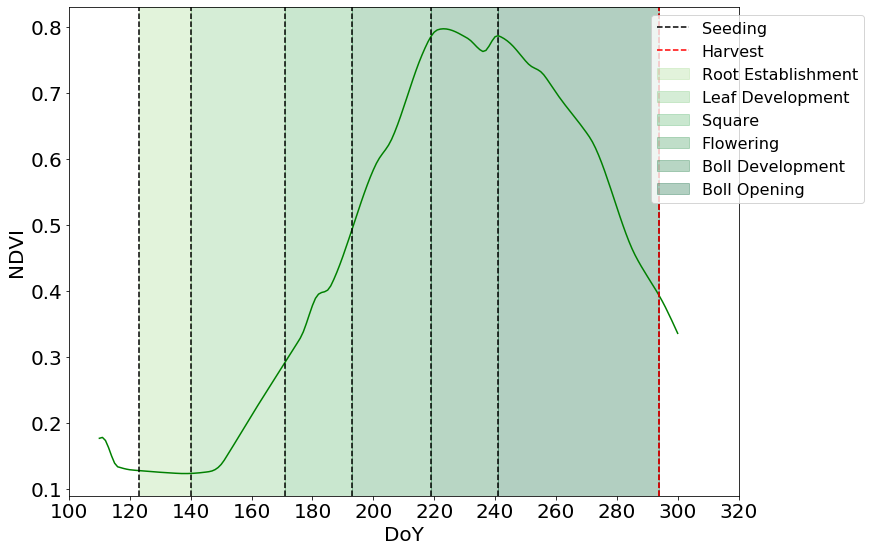

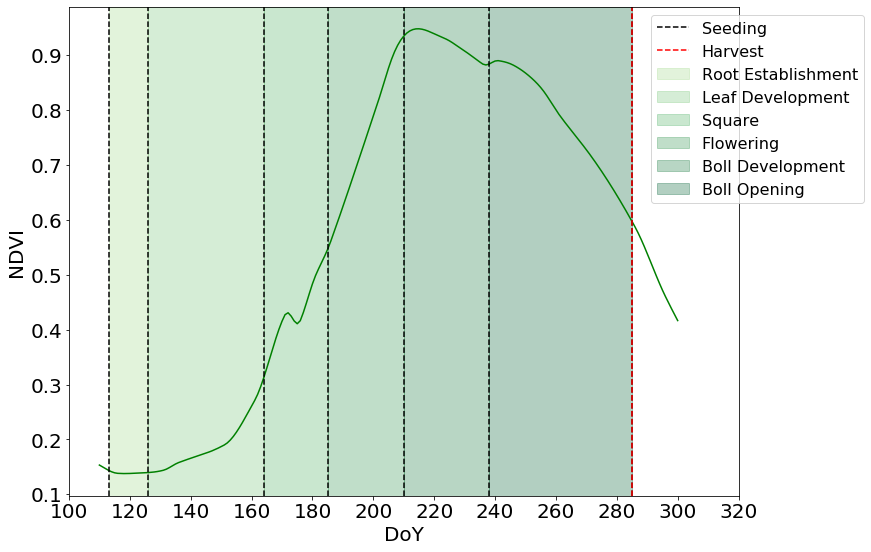

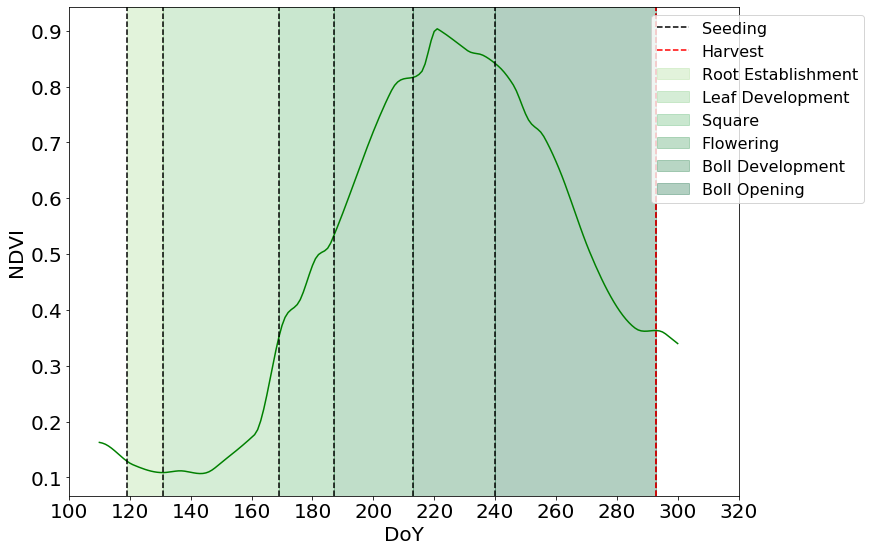

In [3]:
import matplotlib
import numpy as np
x = [int(x.split("_")[1]) for x in ref_values.filter(regex="BARI")]
stages_dict = {100:'Root Establishment',
       200:'Leaf Development',
       300:'Square',
       400:'Flowering', 
       500:'Boll Development', 
       600:'Boll Opening',
       700:'Harvest'}
colors = ['k', 'r', 'b', 'y', 'g', 'm', 'c']
cmap = matplotlib.cm.get_cmap('YlGn')

for key in ref_values.unique_id.unique():
        y = ref_values.loc[ref_values.unique_id == key].filter(regex="NDVI").values[0]/1000
        c = 0.3
        fig, ax = plt.subplots(figsize = (12,9))
        plt.plot(x, y, color = 'g')
        for st, color in zip(range(100,700,100), colors):
            c += 0.1
            doy1 = ref_values.loc[(ref_values.stage == st) & (ref_values.unique_id == key), "doy"].values[0]
            doy2 = ref_values.loc[(ref_values.stage == st+100) & (ref_values.unique_id == key), "doy"].values[0]
            plt.axvspan(doy1, doy2, alpha=0.3, color=cmap(c), label = stages_dict[st])
            plt.axvline(x = doy2, color='k', linestyle='--')
            if st == 100:
                plt.axvline(x = doy1, color='k', linestyle='--', label = 'Seeding')
            if st == 600:
                plt.axvline(x = doy2, color='r', linestyle='--', label = 'Harvest')
        plt.xlabel("DoY", fontsize=20)
        plt.ylabel("NDVI", fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        plt.xticks([x for x in range(100,330, 20)])
        plt.legend(loc = 'upper right', bbox_to_anchor=(1.2, 1), fontsize = 16)
        plt.show()



## Example of phenology extraction
Example of phenology extraction using verbose = 2. Τhe signatures of the best 3 sub-sequences of the reference parcels and the signature of the test parcel are plotted. The example below predicts phenology using only NDVI with a 5-day window.

--------------------------------------
NDVI for parcel 100 at day 200.
Predictions: [343.0, 357.0, 358.0]


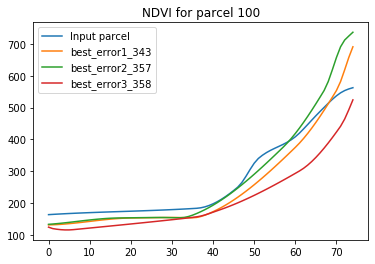

--------------------------------------
NDVI for parcel 100 at day 225.
Predictions: [541.0, 478.0, 553.0]


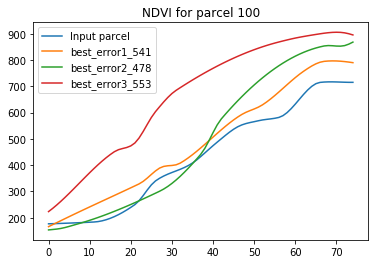

--------------------------------------
NDVI for parcel 100 at day 250.
Predictions: [588.0, 567.0, 571.0]


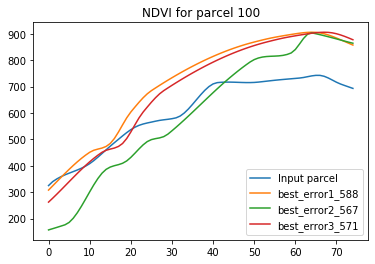

--------------------------------------
NDVI for parcel 100 at day 275.
Predictions: [670.0, 628.0, 680.0]


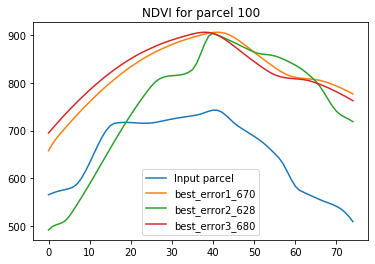

In [158]:
bestN = 11
duration = 75
round_to = 1
end_days = range(200, 300, 25)
phenology_scale_range = {100:(110, 145), 200:(130, 190), 300:(170, 210), 
                           400:(180, 240), 500:(220, 260), 600:(240, 300)}
ndvi_stages = phenology_extraction_for_one_feature(ref_values, end_days, data.iloc[:1,:], phenology_scale_range, 'NDVI',
                        metric = 'mae', stat = 'derivative', bestN = 3,  tw=75, verbose = 2)

## Phenology extraction
Phenology extraction for 16 parcels using all agdd and Sentinel bands (B02-B08, B8A, B11, B12) and vegetation indices NDVI, NDWI, PSRI, BORI and BARI, for every day.

In [5]:
features = ['agdd', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'PSRI', 'BORI', 'BARI']
end_days = range(160, 300)
results = phenology_extraction(ref_values, end_days, data, phenology_scale_range, features, diff_days=5,
                         slack=3, metric="mae", stat='derivative', bestN=3, tw=75, verbose=0)

In [106]:
pd.options.mode.chained_assignment = None 
for i, f in enumerate(features):
    validation["pred_{}_1".format(f)] = validation.apply(lambda x: (int(results[f][x.id][x.doy][0][0]),
                                                            results[f][x.id][x.doy][1][0]), axis = 1)
    validation["pred_{}_2".format(f)] = validation.apply(lambda x: (int(results[f][x.id][x.doy][0][1]),
                                                            results[f][x.id][x.doy][1][1]), axis = 1)
    validation["pred_{}_3".format(f)] = validation.apply(lambda x: (int(results[f][x.id][x.doy][0][2]),
                                                            results[f][x.id][x.doy][1][2]), axis = 1)

# Final phenology estimation

In [145]:
durations = {100:7, 200:35, 300:25, 400:35, 500:20, 600:25}

val = validation.filter(regex = "id|stage|doy|pred")

val["pseudolabel"] = val.filter(regex = 'pred').apply(lambda x: final_stage(x), axis = 1)
val["pseudolabel"] = (10*((val.pseudolabel/10).round())).astype(int)
val["deviation"] = abs(val["pseudolabel"] - val["stage"])

val["stage"] = val.stage.astype(int)

val["mae_doys"] = val.apply(lambda x: mae_to_doys(x.stage, x.pseudolabel, durations), axis = 1)

# Evaluation

In [146]:
print("Mean Doys Distance: (MAE) {:.2f}".format(val.mae_doys.mean()))
print("Mean Stage Error: {:.2f}".format(val.deviation.mean()))

Mean Doys Distance: (MAE) 7.12
Mean Stage Error: 29.52
